In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal
import plotly.express as px

In [4]:
customer_dataset = pd.read_csv('../Data/SMAI-Dataset-customer-dataset/data.csv')
X = np.array(customer_dataset.iloc[:, 1:])
customer_dataset.head()

,Index,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,0,67,2,124670,1,2
1,1,1,1,22,1,150773,1,2
2,2,0,0,49,1,89210,0,0
3,3,0,0,45,1,171565,1,1
4,4,0,0,53,1,149031,1,1


In [31]:
class MyGMM:
    def __init__(self, max_iter=10):
        self.k = 1
        self.num_cols = 1
        self.max_iter = max_iter
        self.means = None
        self.stds = None
        self.probabilities = None
        self.likelihoods = None

    # ---------------------- Utility Methods ---------------------- #
    
    def _gaussian_prob(self, X, mean, cov_matrix):
        """Compute Gaussian probabilities for given data points."""
        epsilon = 1e-2  # Small positive constant
        cov_matrix = np.diag(epsilon + np.diag(cov_matrix))
        likelihoods = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            x = X[i, :]  # Extract one row of X
            diff = x - mean
            exponent = -0.5 * np.dot(diff.T, np.dot(np.linalg.inv(cov_matrix), diff))
            prefactor = 1.0 / (np.sqrt(((2 * np.pi) ** X.shape[1]) * np.linalg.det(cov_matrix)))
            likelihoods[i] = prefactor * np.exp(exponent)

        return likelihoods

    # ---------------------- Initialization Methods ---------------------- #
    
    def preprocess(self, X):
        """Normalize the data."""
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        return (X - min_vals) / (max_vals - min_vals)

    def initialise_parameters(self, X):
        """Initialize means, covariances, and probabilities using KMeans."""
        self.num_cols = X.shape[1]
        kmeans = KMeans(n_clusters=self.k, init='k-means++')
        kmeans.fit(X)
        self.means = kmeans.cluster_centers_

        initial_covariances = [np.cov(X[kmeans.labels_ == cluster_label], rowvar=False) for cluster_label in range(self.k)]
        self.stds = np.array([np.diag(np.diag(std)) for std in initial_covariances])

        self.probabilities = np.random.rand(self.k)
        self.probabilities /= np.sum(self.probabilities)

    # ---------------------- E-Step and M-Step Methods ---------------------- #
    
    def compute_likelihoods(self, X):
        """E-step: Compute likelihoods for each data point."""
        likelihoods = np.zeros((self.k, X.shape[0]))
        for i in range(self.k):
            likelihoods[i] = self.probabilities[i] * self._gaussian_prob(X, self.means[i], self.stds[i])
        self.likelihoods = likelihoods / np.sum(likelihoods, axis=0)

    def update_parameters(self, X):
        """M-step: Update means, covariances, and probabilities."""
        means = np.zeros((self.k, self.num_cols))
        stds = np.zeros((self.k, self.num_cols, self.num_cols))
        probs = np.zeros(self.k)

        for i in range(self.k):
            probs[i] = np.sum(self.likelihoods[i]) / X.shape[0]
            X_centered = X - self.means[i]
            for j in range(X.shape[0]):
                means[i] += self.likelihoods[i][j] * X[j]
                stds[i] += self.likelihoods[i][j] * (X_centered[j].T.dot(X_centered[j]))
            means[i] /= np.sum(self.likelihoods[i])
            stds[i] /= np.sum(self.likelihoods[i])

        self.means = means
        self.stds = stds
        self.probabilities = probs / np.sum(probs)

    # ---------------------- Fit and Predict Methods ---------------------- #
    
    def fit(self, X, k):
        """Fit the GMM to the data."""
        self.k = k
        self.initialise_parameters(X)
        for _ in range(self.max_iter):
            self.compute_likelihoods(X)
            self.update_parameters(X)

    def predict(self, X):
        """Predict the cluster for each data point."""
        probs = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            probs[:, i] = self.probabilities[i] * self._gaussian_prob(X, self.means[i], self.stds[i])
        return np.argmax(probs, axis=1)

    # ---------------------- Model Evaluation Methods ---------------------- #
    
    def get_loglikelihood(self, X):
        """Compute the log likelihood of the data given the model."""
        loglikelihood = 0
        for i in range(self.k):
            loglikelihood += self.probabilities[i] * self._gaussian_prob(X, self.means[i], self.stds[i])
        return np.sum(np.log(loglikelihood))

    def get_aic(self, X):
        """Compute the Akaike Information Criterion."""
        loglikelihood = self.get_loglikelihood(X)
        num_parameters = self.k * (2 * self.num_cols + 1)
        return -2 * loglikelihood + 2 * num_parameters

    def get_bic(self, X):
        """Compute the Bayesian Information Criterion."""
        loglikelihood = self.get_loglikelihood(X)
        num_parameters = self.k * (2 * self.num_cols + 1)
        return -2 * loglikelihood + num_parameters * np.log(X.shape[0])

    # ---------------------- Getter for Model Parameters ---------------------- #
    
    def get_parameters(self):
        """Return the means, covariances, and probabilities."""
        return self.means, self.stds, self.probabilities

## Visualizing the wine dataset

In [21]:
from sklearn.datasets import load_wine
from sklearn.mixture import GaussianMixture

data = load_wine()
X_wine = data.data
y_wine = data.target

In [22]:
# plot the data
fig = px.scatter_3d(x=X_wine[:,0], y=X_wine[:,1], z = X_wine[:,2], color=y_wine)
fig.show()

In [33]:
model = MyGMM(max_iter = 20)
model.fit(X , 3)

/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

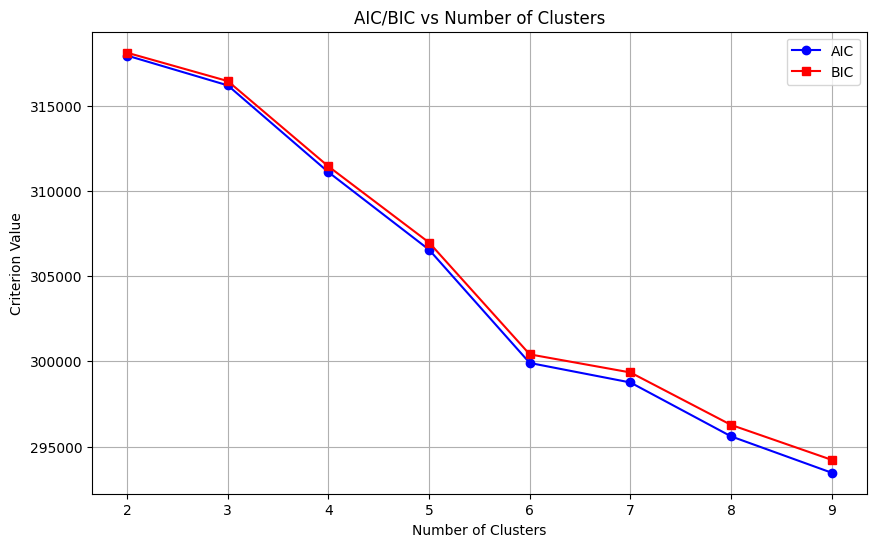

In [35]:
def train_gmm_models(X, cluster_range):
    """Train GMM models for a range of cluster numbers."""
    models = [MyGMM() for _ in cluster_range]
    for i, model in enumerate(models):
        model.fit(X, cluster_range[i])
    return models

def compute_criteria(models, X):
    """Compute AIC and BIC for each model."""
    aic = [model.get_aic(X) for model in models[1:]]
    bic = [model.get_bic(X) for model in models[1:]]
    return aic, bic

def plot_criteria(cluster_range, aic, bic):
    """Plot AIC and BIC against the number of clusters using matplotlib."""
    
    plt.figure(figsize=(10, 6))
    
    # Plot AIC values
    plt.plot(cluster_range, aic, marker='o', label='AIC', color='blue')
    
    # Plot BIC values
    plt.plot(cluster_range, bic, marker='s', label='BIC', color='red')
    
    plt.title('AIC/BIC vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Criterion Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
cluster_range = np.arange(1, 10, 1)
models = train_gmm_models(X, cluster_range)
aic, bic = compute_criteria(models, X)
plot_criteria(cluster_range[1:], aic, bic)


/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/arjundosajh/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



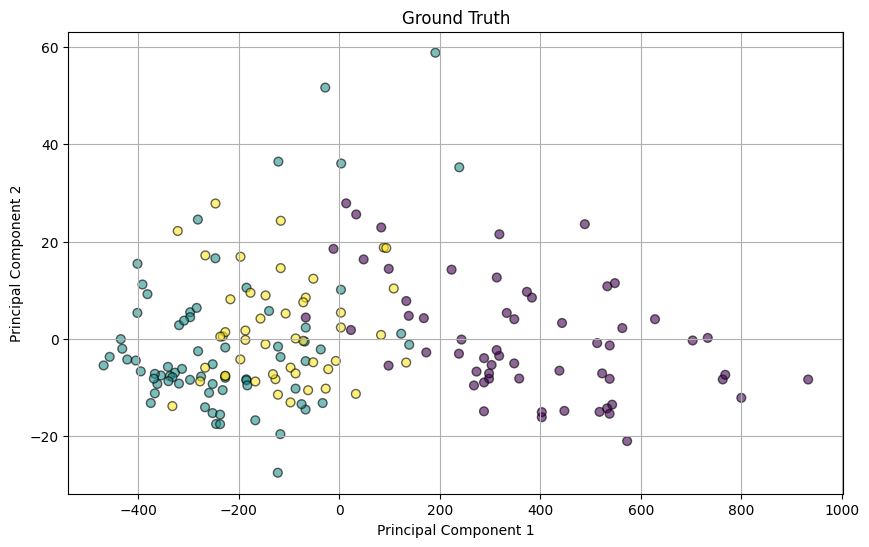

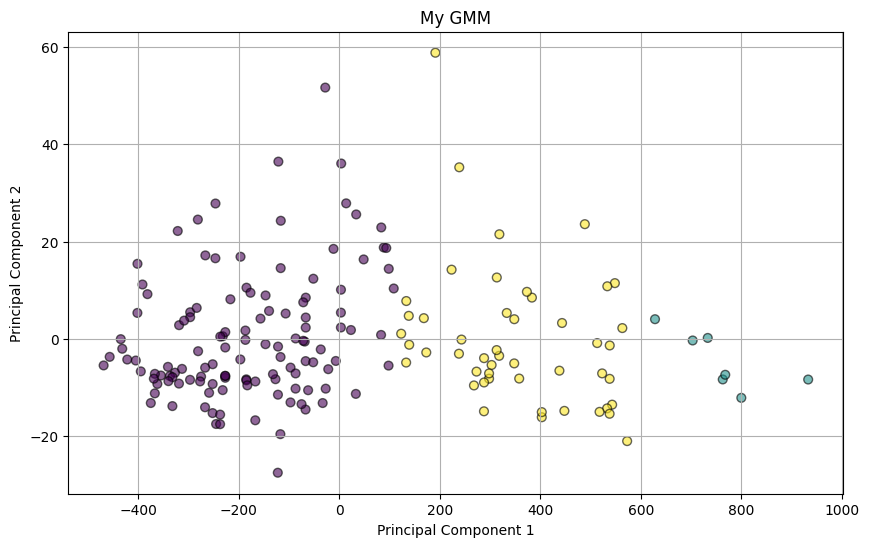

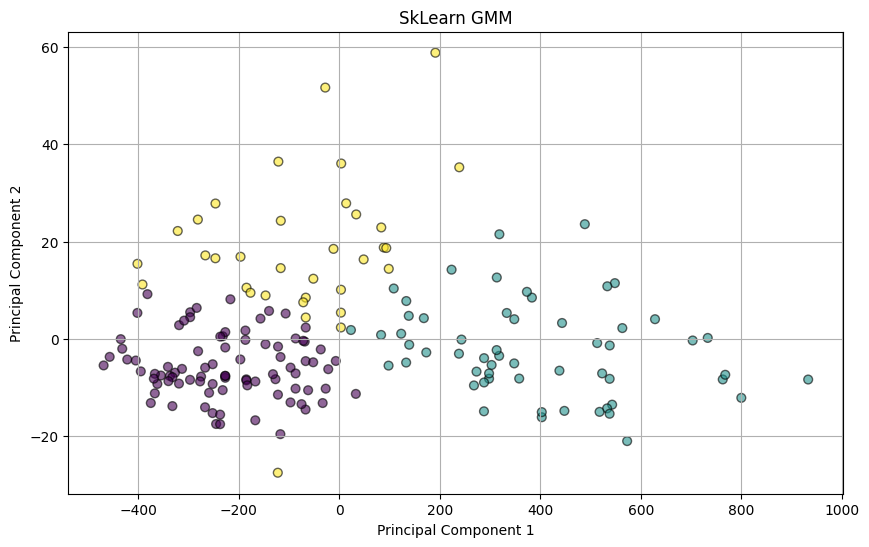

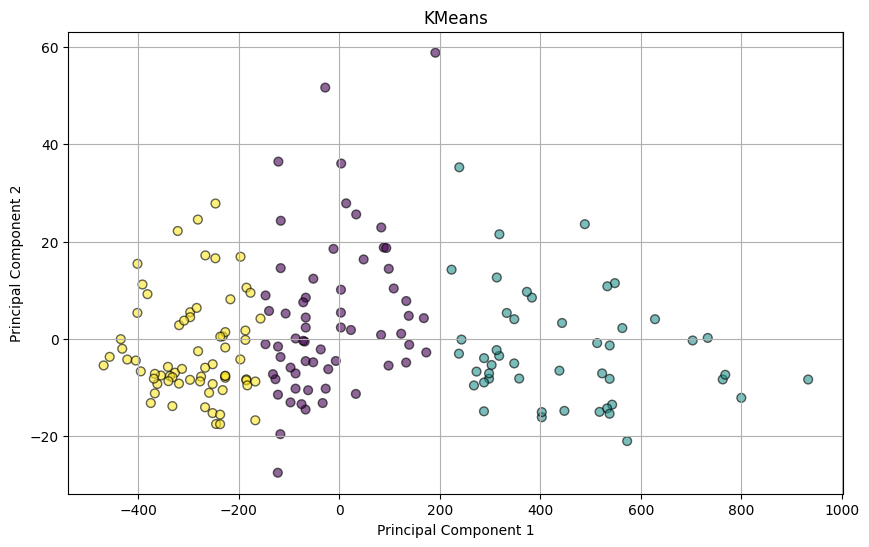

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_wine)
y_wine = data.target

my_gmm = MyGMM(max_iter = 50)
gmm_model = GaussianMixture(n_components=3, covariance_type='full')
kmeans_model = KMeans(n_clusters=3, random_state=42)

my_gmm.fit(X_pca , 3)
gmm_model.fit(X_pca)
kmeans_model.fit(X_pca)

my_gmm_labels = my_gmm.predict(X_pca)
gmm_probs = gmm_model.predict_proba(X_pca)
gmm_labels = np.argmax(gmm_probs , axis = 1)

kmeans_labels = kmeans_model.predict(X_pca)

def plot_pca_data(X_pca, labels, title):
    """Plot PCA-transformed data with given labels."""
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=40, alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

# Plotting the data with different labels
plot_pca_data(X_pca, y_wine, 'Ground Truth')
plot_pca_data(X_pca, my_gmm_labels, 'My GMM')
plot_pca_data(X_pca, gmm_labels, 'SkLearn GMM')
plot_pca_data(X_pca, kmeans_labels, 'KMeans')


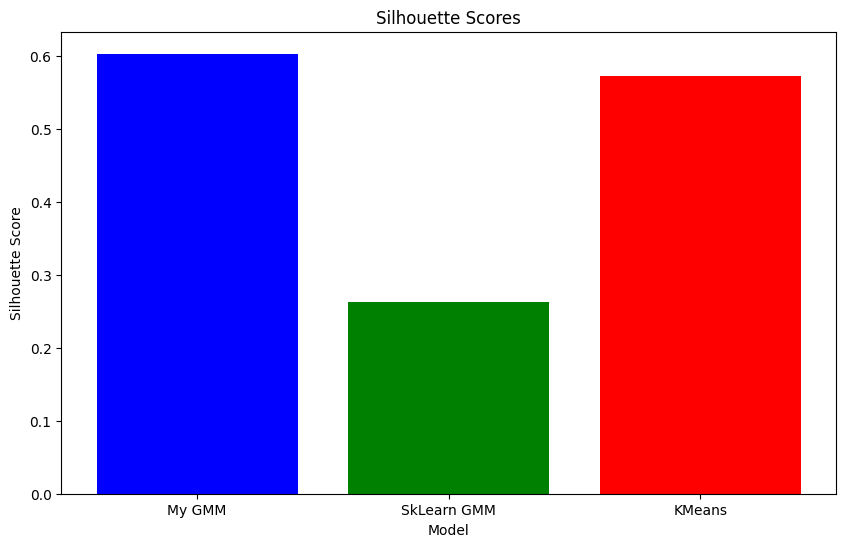

In [48]:
my_gmm_score = silhouette_score(X_pca , my_gmm_labels)
gmm_score = silhouette_score(X_pca , gmm_labels)
kmeans_score = silhouette_score(X_pca , kmeans_labels)

scores = [my_gmm_score , gmm_score , kmeans_score]
labels = ['My GMM' , 'SkLearn GMM' , 'KMeans']

def plot_silhouette_scores(labels, scores):
    """Plot silhouette scores for different models."""
    plt.figure(figsize=(10, 6))
    plt.bar(labels, scores, color=['blue', 'green', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores')
    plt.show()

plot_silhouette_scores(labels, scores)